<a href="https://colab.research.google.com/github/usef-kh/EC523-Deep-Learning-Project/blob/master/CNN%20Ensemble/VGGnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [3]:
%%capture
!git clone "https://github.com/usef-kh/EC523-Deep-Learning-Project.git"
!pip install unrar
!unrar e "EC523-Deep-Learning-Project/datasets/fer2013.rar"

##Imports

In [13]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.models as models

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Load Dataset

In [5]:
fer2013 = pd.read_csv('fer2013.csv') 
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
fer2013.head()

transform = transforms.Normalize(mean=129.4456, std = 1)

def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
xval , yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

In [8]:
class Fer2013(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform        
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)
        
        return sample

mu, st = 0, 255
train_transform = transforms.Compose([
                    transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
                    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ])

train = Fer2013(xtrain, ytrain, train_transform)
val = Fer2013(xval, yval, test_transform)
test = Fer2013(xtest, ytest, test_transform)

In [9]:
trainloader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, num_workers=2)

Batch Images Shape: torch.Size([100, 1, 48, 48])
Batch Labels Shape: torch.Size([100])

Neutral    Fear    Fear    Fear   Angry


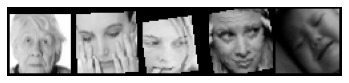

In [10]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Batch Images Shape:", images.shape)
print("Batch Labels Shape:", labels.shape)
print()

# show 5 images
imshow(torchvision.utils.make_grid(images[:5]))
plt.axis('off')
# print labels
print(' '.join('%7s' % emotions[labels[j].item()] for j in range(5)))

##Model

In [14]:
class History:
    def __init__(self):
        self.loss_train = []
        self.loss_val = []

        self.acc_train = []
        self.acc_val = []

In [26]:
class reVgg(nn.Module):
  def __init__(self):
    super(reVgg, self).__init__()
    self.convert = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1)
    
    vgg = models.vgg19(pretrained=True).features
    vgg.to(device)
    vgg.eval()

    self.vgg = vgg 

    self.lin1= nn.Linear(512 * 1 * 1, 7)
    self.history = History()

  def forward(self, x):
    x = self.convert(x)

    x = self.vgg(x)
    x = x.view(-1, 512 * 1 * 1)
    x = self.lin1(x)

    return x

##Training

In [27]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(net, trainloader, valloader, n_epochs=20):
    
    for epoch in range(n_epochs):
        
        net = net.train()
        loss_tr, correct_count, n = 0.0, 0.0, 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculate performance metrics
            loss_tr += loss.item()
            
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n += labels.size(0)
            
        # Save train and validation performance metrics 
        acc_tr = 100 * correct_count / n
        loss_tr = loss_tr / n

        acc_v, loss_v = test_model(net, valloader)

        net.history.loss_train.append(loss_tr)
        net.history.loss_val.append(loss_v)

        net.history.acc_train.append(acc_tr)
        net.history.acc_val.append(acc_v)
        scheduler.step(acc_v)

        print('Epoch %2d' % (epoch + 1), 'Train Accuracy: %2.2f %%' % (acc_tr), 'Val Accuracy: %2.2f %%' % (acc_v), sep='\t\t')

In [28]:
def test_model(net, dataloader):
    
    net = net.eval()

    loss, correct_count, n_sampels = 0.0, 0.0, 0.0
    for data in dataloader:

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        loss += criterion(outputs, labels).item()

        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_sampels += labels.size(0)
    
    acc = 100 * correct_count / n_sampels
    loss = loss / n_sampels
    
    return acc, loss

In [ ]:
model = reVgg()
model = model.to(device)


learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)
criterion = nn.CrossEntropyLoss()
train_model(model, trainloader, valloader, n_epochs=150)

##Evaluation

In [23]:
def plot_metrics(net):
    plt.figure()
    plt.plot(net.history.acc_train, 'g', label='Training Acc')
    plt.plot(net.history.acc_val, 'b', label='Validation Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(net.history.loss_train, 'g', label='Training Loss')
    plt.plot(net.history.loss_val, 'b', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    print('Training Accuracy: %2.2f %%' % (max(net.history.acc_train)))
    print('Validation Accuracy: %2.2f %%' % (max(net.history.acc_val)))
    print()

    acc, loss = test_model(net, testloader)    
    print('Test Accuracy: %2.2f %%' % (acc))
    print('Average Test Loss: %2.4f' % (loss))
    

VGG model


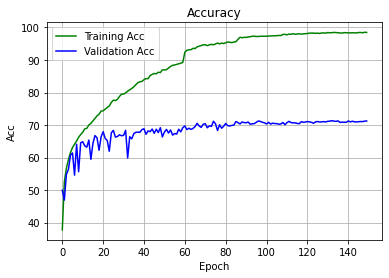

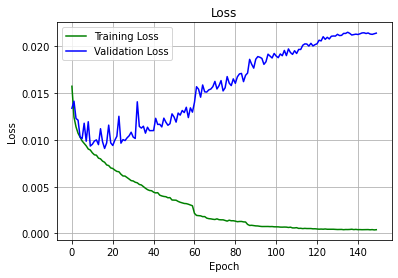

Training Accuracy: 98.54 %
Validation Accuracy: 71.33 %

Test Accuracy: 70.83 %
Average Test Loss: 0.0227


In [24]:
print("VGG model")
plot_metrics(model) 

### Subnets

##Save Model

In [25]:
path = 'vgg'
torch.save(model.state_dict(), path)

In [ ]:
# from google.colab import files
# files.download(path)